<a href="https://colab.research.google.com/github/EddieOrmseth/MAT-421/blob/main/Project/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction:

The problem statement is fairly simple: I will be investigating ways to use interpolation to fill in missing data for tracking moving objects in different sports.

Many sports, such as soccer, tennis, and golf, use technology to track the location of the balls in real time. This allows for incredible precision in deciding if there was a goal in soccer or if the ball was in or out in tennis. It also allows for a better watching experience, a small white golf ball in the sky is hard to track with your eyes and so they display a line that follows the entire path of the ball as it travels.

What happens if some of this data is not available? This could be for a variety of reasons. Perhaps something blocks the ball from the camera and inhibits the vision system from tracking it, as most sports have many moving people who could easily obscur things. Maybe the sensor data has been lost among in transition from sensor to computer, sporting events bring in thousands of people to view in one area and create seas of electromagnetic radiation. There could simply be a glitch in the sporting system, software often has such glitches.

To address this problem of missing data, I will be exploring different interpolation techniques and their ability to re-create the data effectively. I will explore specifically the methods of Spline, Newtwon, and Lagrange interpolation.

Math Methods:

I will use a variety of interpolation techniques, this is the interface that will define the types that can be substituted in and out of my interpolation algorithms.

I also included a short example function that will be used to provide a basic test / demonstration of each of the interpolations to be used.

In [37]:
import numpy as np
import matplotlib.pyplot as plt


class Interpolator:

    def interpolate_missing_values(self, x: np.array, y: np.array) -> np.array:
        raise "Interpolator::interpolate_missing_values must be implemented"
    
    def name(self):
        raise "Interpolator::name must be implemented"


def interp_example(interp: Interpolator):

    # x = np.linspace(0, 10, 1001)
    x = np.linspace(10, 20, 1001)
    y = np.zeros_like(x)
    for i in range(len(y)): y[i] = np.nan

    pts_x = [0, 2, 3, 6, 8, 10]
    pts_y = [1, 5, 3, 2, 8, 1]
    for i in range(len(pts_x)):
        idx = np.argmin(np.abs(x - pts_x[i]))
        y[idx] = pts_y[i]

    y_interp = interp.interpolate_missing_values(x, y)

    plt.plot(pts_x, pts_y, 'o', label='Original Points')
    plt.plot(x, y_interp, '--', label='Spline Curve')
    plt.legend()
    plt.show()


Linear Interpolation:

This is a simple method that will be used primarily for reference against the other functions. It is not intended to be a genuine solution, but rather provides the context of a very naive solution.

It works exactly as you would imagine: for a missing x, the points on either side of it are found. These values are then used to create a line, this line is then used to predict x's corresponding y value.

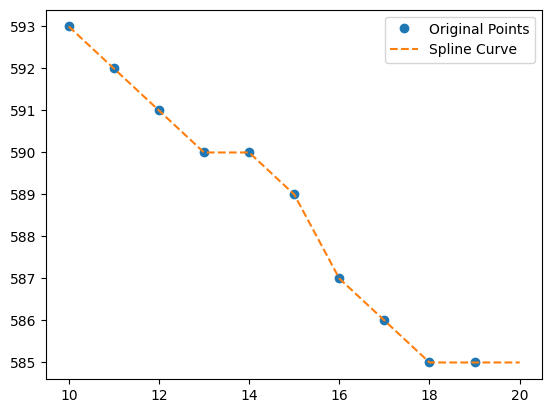

In [38]:
import sys
import numpy as np


try:
    from Interpolation import Interpolator, interp_example
except:
    cat = 12


class PiecewiseLinearInterpolator(Interpolator):

    def interpolate_missing_values(self, x: np.array, y: np.array) -> np.array:
        present_indices = np.where(~np.isnan(y))[0]
        missing_indices = np.where(np.isnan(y))[0]

        x_present = x[present_indices]
        y_present = y[present_indices]
        y_interp = y.copy()

        for i in missing_indices:
            i_larger, i_smaller = self.find_surrounding_pts(x_present, x[i])
            if i_larger == -1 or i_smaller == -1: continue

            y_interp[i] = y_present[i_smaller] + ((y_present[i_larger] - y_present[i_smaller]) / (x_present[i_larger] - x_present[i_smaller])) * (x[i] - x_present[i_smaller])

        return y_interp


    def find_surrounding_pts(self, data, x):
        if x <= data[0]: return 0, 1
        elif data[-1] <= x: return len(data) - 2, len(data) - 1
        
        for i in range(len(data) - 1):
            if data[i] <= x <= data[i + 1]:
                return i, i + 1
        return 0, 1
            
            
    def name(self):
        return "Piecewise Linear"
    

if __name__ == '__main__':

    interp_example(PiecewiseLinearInterpolator())


Spline Interpolation:

This method is a little more complex than the last, and will certainly serve to get some good data. It works by treating every two successive points as the basic for an equation. It generates a separate polynomial for each sequential pair of points, but links them with some inforation. The polynomials it creates have to go through the points, but they must also have the same derivative at the point to ensure a smooth transition. Exactly what qualities of smoothness are enforced is somewhat left to the implementation, but typically a cubic spline would enforce continuity in the zeroth, first, and second derivatives.

For their high level of continuity while still retaining a low order, cubic splines have be dubbed "natural" splines. And while these are the most common, quintic splines are also common. In addition to this, there is also a parameter that allows some additional smoothing of the function at the expense of going exactly through each point. Below is a standard natural spline, and a quintic spline with some small smoothing enabled.

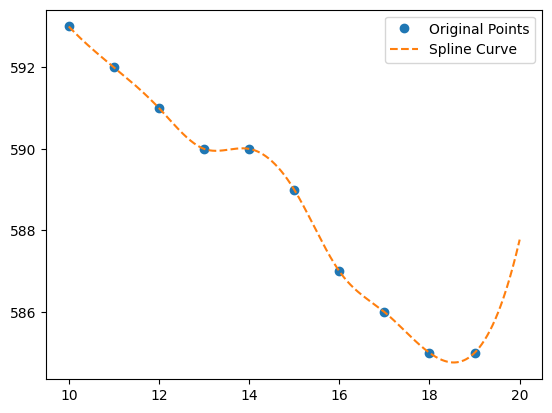

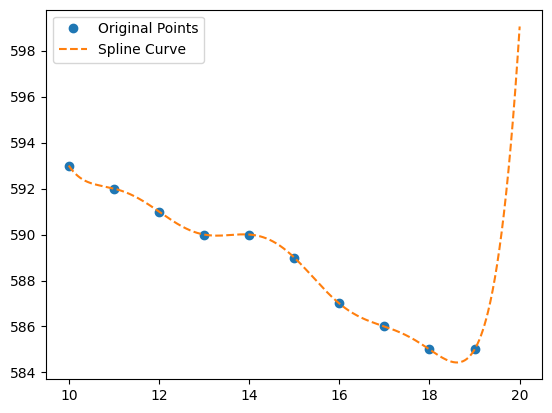

In [39]:
import sys
import numpy as np
from scipy.interpolate import UnivariateSpline


try:
    from Interpolation import Interpolator, interp_example
except:
    cat = 12


class SplineInterpolator(Interpolator):

    k: int = 3
    s: int = 0


    def __init__(self, k: int = 3, s: int = 0):
        self.k = k
        self.s = s


    def interpolate_missing_values(self, x: np.array, y: np.array) -> np.array:
        mask = ~np.isnan(y)
        spline = UnivariateSpline(x[mask], y[mask], k=self.k, s=self.s)
        y_interp = y.copy()
        missing_indices = np.where(np.isnan(y))[0]
        y_interp[missing_indices] = spline(x[missing_indices])
        return y_interp
    
    
    def name(self):
        if self.k == 3: return "Cubic Spline"
        if self.k == 5: return "Quintic Spline"
        else: return "Spline"


if __name__ == '__main__':

    interp_example(SplineInterpolator(k = 3, s =0))
    interp_example(SplineInterpolator(k = 5, s = 0))


Newton Interpolation:

This is a high-level polynomial implementation, that fortunately manages to do a good job of mitigating the issue of high-level polynomials flying wildly out of control. Splines rarely get above the 5th order due to this issue, but with some clever coefficient control Newton's Interpolation manages to control it well.

The Newton polynomial has the form:

    P(x) = a0 + a1(x - x0) + a2(x - x0)(x - x1) + ... + an(x - x0)...(x - xn-1)

A couple things are of note in this method:

1. The ai's: these are coefficients that are determined by a divided difference method. This can get a little convoluded, but what it really means is that
f(xi) = yi, f(xi, xi+1) = (f(xi+1) - f(xi)) / (xi+1 - x), f(xi-1, xi, xi+1) = f(f(xi, xi+1) - (xi-1, xi)) / (xi+1 - xi-1), and so on and on. This table can be calculated once at the beginning, and then repurposed for every subsequent call, making the algorithm somewhat efficient.

2. The (x - xi)'s: these help determine what terms are influencing at which points. Notice that at point xi, only terms with n > i influence the equation, so that it can cross the given point exactly.

3. Finally, one important property of this method is that it is easily extendible. If we need to add the term n+1, then none of the i < n+1 terms are at all affected. This means that new points can be appended to the method without recomputing any information, which can be a huge advantage. Especially in the context of predicting future values.


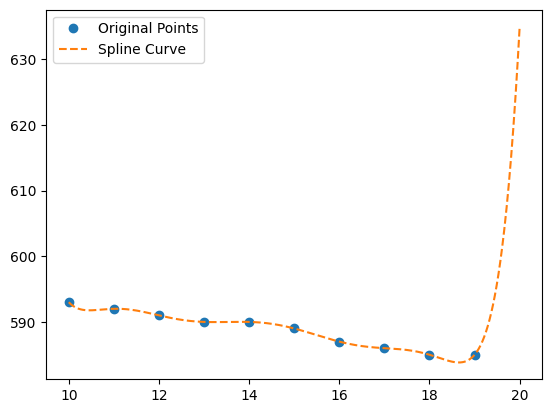

In [40]:
import sys
import numpy as np


try:
    from Interpolation import Interpolator, interp_example
except:
    cat = 12


class NewtonInterpolator(Interpolator):

    def interpolate_missing_values(self, x: np.array, y: np.array) -> np.array:
        mask = ~np.isnan(y)
        coefs = self.divided_differences(x[mask], y[mask])

        y_interp = y.copy()
        for i in range(len(x)):
            if np.isnan(y_interp[i]):
                y_interp[i] = self.newton_poly_eval(x[mask], coefs, x[i])

        return y_interp


    def divided_differences(self, x, y):
        n = len(x)
        coef = np.array(y, dtype=float)
        for j in range(1, n):
            coef[j:] = (coef[j:] - coef[j - 1:-1]) / (x[j:] - x[:n - j])
        return coef


    def newton_poly_eval(self, x_data, coef, x):
        result = 0
        basis_product = 1  # initially, this is 1 (for the a_0 term)

        for i in range(len(coef)):
            result += coef[i] * basis_product
            basis_product *= (x - x_data[i])  # build up (x - x0)(x - x1)... step-by-step

        return result
    
    
    def name(self):
        return "Newton"


if __name__ == '__main__':
    
    interp_example(NewtonInterpolator())


Lagrange Interpolation:

The definition for this type of interpolation is a little convoluded, but bear with me.

For the set of points (x0, yi)...(xn, yn)

    P(x) = (y0 * L0(x)) + ... + (yn * Ln(x))

where Li(x) =

    product((x - xm) / (xi - xm)) from 0 <= m <= n, and i != m

The result of this Li(x) term is that when P(x) is evaluated at xi, then there is only 1 term that is activated. All the other terms are zeroed out by their (x - xi) term. This ensures that the function goes exactly through each given point. The function is also made up of only polynomials, and so is indeed continuous.

The other terms serve to help smooth things along varying the influence of each vertex as you move through the function.

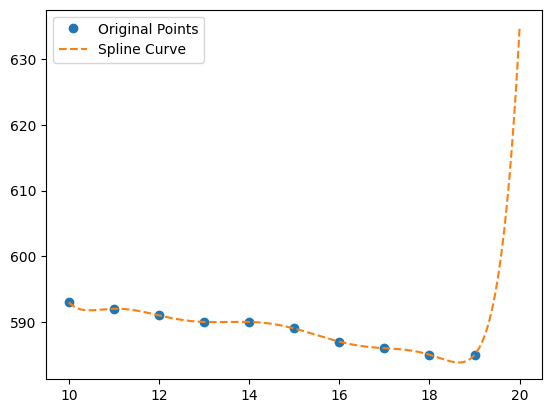

In [41]:
import sys
import numpy as np
from scipy.interpolate import lagrange


try:
    from Interpolation import Interpolator, interp_example
except:
    cat = 12


class LagrangeInterpolator(Interpolator):


    def interpolate_missing_values(self, x: np.array, y: np.array) -> np.array:
        mask = ~np.isnan(y)
        interp_func = lagrange(x[mask], y[mask])
        missing_indices = np.where(np.isnan(y))
        y_interp = y.copy()
        y_interp[missing_indices] = interp_func(x[missing_indices])
        return y_interp
    

    def name(self):
        return "Lagrange"


if __name__ == '__main__':

    interp_example(LagrangeInterpolator())


Data: I have so far integreated two datasets. One for the position of a soccer ball on a picture, and the other for the position of a tennis ball on the picture.

To bring these data sets in, I wrote a DataLoader class. This allows me to load smaller amounts of data at a time, and doesn't require test info to be kept in memory for a long time. I also found the resolution of each picture, and scaled the coordinates to be between 0 and 1. This way, the error that is output will not be scaled differnetly for images with different resolutions. The DataLoader class, along with the normalization logic is below.

In [42]:
import os
import numpy as np
import pandas as pd


class DataLoader:

    t_data: np.array = None
    x_data: np.array = None
    y_data: np.array = None


    def load(self):
        raise "DataLoader::load must be implemented"
    

    def name(self):
        raise "DataLoader::name must be implemented"
    

    def getIdx(self):
        raise "DataLoader::getIDx must be implemented"


class TennisDataLoader(DataLoader):

    path: str = ""
    idx: int = -1


    def __init__(self, path: str, idx: int):
        self.path = path


    def load(self):
        data = pd.read_csv(self.path)

        self.x_data = data["x-coordinate"].to_numpy(dtype=np.float32)
        self.y_data = data["y-coordinate"].to_numpy(dtype=np.float32)

        raw_t_data = data["file name"]
        self.t_data = np.zeros_like(self.x_data, dtype=np.float32)
        for i in range(len(self.t_data)): self.t_data[i] = float(raw_t_data[i][0:4])

        valid_t = np.where(~np.isnan(self.x_data))
        self.t_data = self.t_data[valid_t]
        self.x_data = self.x_data[valid_t]
        self.y_data = self.y_data[valid_t]

        self.x_data = ((self.x_data) / (1280.0))
        self.y_data = ((self.y_data) / (720.0))


    def name(self):
        return "Tennis"


    def getIdx(self):
        return self.idx
    

class SoccerDataLoader(DataLoader):

    path: str = ""
    idx: int = -1


    def __init__(self, path: str, idx: int):
        self.path = path


    def load(self):
        data = pd.read_csv(self.path, header=None)

        block = data[1].to_numpy(dtype=np.float32)
        self.t_data = data[0].to_numpy(dtype=np.float32) + (block - 1) * 750
        self.x_data = data[2].to_numpy(dtype=np.float32)
        self.y_data = data[3].to_numpy(dtype=np.float32)

        valid_t = np.where(~np.isnan(self.x_data))
        self.t_data = self.t_data[valid_t]
        self.x_data = self.x_data[valid_t]
        self.y_data = self.y_data[valid_t]

        self.x_data = ((self.x_data) / (1920.0))
        self.y_data = ((self.y_data) / (1080.0))


    def name(self):
        return "Soccer"


def make_all_data_loaders() -> list[TennisDataLoader]:
    loaders = []

    tennis_path = os.path.join(os.path.dirname("C:\\Users\\eddie\\OneDrive\\Documents\\Career\\Education\\Classes\\College\\Junior Year\\Semester 2\\MAT 412 Applied Computational Methods\\MAT-421\\Project\\"), "data\\tennis")
    i: int = 0
    for entry in os.scandir(tennis_path):
        loaders.append(TennisDataLoader(entry.path, i))
        i += 1

    scocer_path = os.path.join(os.path.dirname("C:\\Users\\eddie\\OneDrive\\Documents\\Career\\Education\\Classes\\College\\Junior Year\\Semester 2\\MAT 412 Applied Computational Methods\\MAT-421\\Project\\"), "data\\soccer")
    i = 0
    for entry in os.scandir(scocer_path):
        loaders.append(SoccerDataLoader(entry.path, i))
        i += 1
    
    return loaders


Testing: 

to facilitate testing, I wrote some powerful code that will run every combination of the test case configurations, interpolations, and datasets. It is a cery useful tool, that also outputs error information in a JSON format afterwards. The error information is kept in a dictionary to support this.

In [43]:
from DataLoader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


class TestCase:

    t_data: np.array = None
    x_data: np.array = None
    x_true: np.array = None
    y_data: np.array = None
    y_true: np.array = None


class TestConfiguration:

    name_str: str
    mask: str
    size: int = -1


    def __init__(self, name_str: str, mask):
        self.name_str = name_str + ": ["
        self.mask = mask
        self.size = len(mask)
        
        for i in range(len(mask)): self.name_str += str(mask[i]) + ", "
        self.name_str = self.name_str[:len(self.name_str) - 2]
        self.name_str += "]"

        for i in range(self.size): 
            if mask[i] == 0: mask[i] = np.nan
            elif not np.isnan(mask[i]): mask[i] = 1


    def name(self):
        return self.name_str


    def configure(self, loc: int, t_data: np.array, x_data: np.array, y_data: np.array) -> TestCase:
        if loc < 0 or len(t_data) < loc + self.size: return None

        t: TestCase = TestCase()
        t.t_data = t_data[loc:loc + self.size]
        t.x_true = x_data[loc:loc + self.size]
        t.y_true = y_data[loc:loc + self.size]

        t.x_data = t.x_true.copy() * self.mask
        t.y_data = t.y_true.copy() * self.mask

        return t


def get_results_dict() -> dict:
    return { "total error" : 0.0, "num cases" : 0.0, "average error": 0.0 }


class Tester:

    test_configs = list[TestConfiguration]
    loaders: list[DataLoader]
    interpolators: list[Interpolator]
    results: dict = {}

    datasets: set = set()

    def setup_results(self):
        for config in self.test_configs:
            self.results.update({ config.name() : {} })
            for loader in self.loaders:
                self.results[config.name()].update({ loader.name() : {} })
                for interp in self.interpolators:
                    self.results[config.name()][loader.name()].update({ interp.name() : get_results_dict() })

    
    def compute_test_case(self, interpolator: Interpolator, t_data, x_data: np.array, x_true: np.array, y_data: np.array, y_true: np.array):
        x_pred = interpolator.interpolate_missing_values(t_data, x_data)
        y_pred = interpolator.interpolate_missing_values(t_data, y_data)

        errors = np.sqrt((x_true - x_pred) ** 2 + (y_true - y_pred) ** 2)
        error = np.sum(errors)
        mean_true_x = np.mean(x_true)
        mean_true_y = np.mean(y_true)
        total_variance = np.sqrt((x_true - mean_true_x) ** 2 + (y_true - mean_true_y) ** 2)
        ss_res = np.sum(errors ** 2)
        ss_tot = np.sum(total_variance ** 2)

        # if error > 1000:
        #     t_more = np.linspace(np.min(t_data), np.max(t_data), 100)
        #     x_more = np.full_like(t_more, np.nan)
        #     y_more = np.full_like(t_more, np.nan)
        #     for i in range(len(t_data)):
        #         idx = np.argmin(np.abs(t_more - t_data[i]))
        #         x_more[idx] = x_data[i]
        #         y_more[idx] = y_data[i]

        #     x_more_pred = interpolator.interpolate_missing_values(t_more, x_more)
        #     y_more_pred = interpolator.interpolate_missing_values(t_more, y_more)
        #     xR2 = r2_score(x_true, x_pred)
        #     yR2 = r2_score(y_true, y_pred)

        #     plt.plot(t_data, x_true, 'o', label='X Original Points')
        #     plt.plot(t_more, x_more_pred, '--', label='X ' + interpolator.name() + " Estimate: " + str(xR2) + " r2")
        #     plt.legend()
        #     plt.show()
            
        #     plt.plot(t_data, y_true, 'o', label='Y Original Points')
        #     plt.plot(t_more, y_more_pred, '--', label='Y ' + interpolator.name() + " Estimate: " + str(yR2) + " r2")
        #     plt.legend()
        #     plt.show()

        return error, ss_res, ss_tot
    

    def run_all_tests(self):
        while len(self.loaders) > 0:
            loader = self.loaders.pop()
            loader.load()
            self.datasets.add(loader.name())
            for config in self.test_configs:
                length = len(loader.t_data)
                idxs = [int(((i + 1.0) / 6.0) * float(length)) for i in range(5)]
                testcases = [config.configure(idx, loader.t_data, loader.x_data, loader.y_data) for idx in idxs]
                for t in testcases:
                    if t is None: continue
                    for interp in self.interpolators:
                        error, ss_res, ss_tot = self.compute_test_case(interp, t.t_data, t.x_data, t.x_true, t.y_data, t.y_true)
                        self.results[config.name()][loader.name()][interp.name()]["total error"] += error
                        self.results[config.name()][loader.name()][interp.name()]["num cases"] += 1


    def consolidate_results(self):
        error_by_test_config: dict = {}
        for config in self.test_configs:
            error_by_test_config.update({ config.name() : 0.0 })

        error_by_interpolation: dict = {}
        for interp in self.interpolators:
            error_by_interpolation.update({ interp.name() : 0.0 })

        error_by_dataset: dict = {}
        for dataset in self.datasets:
            error_by_dataset.update({ dataset : 0.0 })

        for config in self.test_configs:
            for dataset in self.datasets:
                for interp in self.interpolators:
                    avgError: float = self.results[config.name()][dataset][interp.name()]["total error"] / self.results[config.name()][dataset][interp.name()]["num cases"]
                    self.results[config.name()][dataset][interp.name()]["average error"] = avgError
                    error_by_test_config[config.name()] += avgError
                    error_by_interpolation[interp.name()] += avgError
                    error_by_dataset[dataset] += avgError

        return { "Results" : self.results, "Error by Test Config" : error_by_test_config, "Error by Interpolation" : error_by_interpolation, "Error by Dataset" : error_by_dataset }


Testing: 

One very important realization came from my initial testing: Lagrange isn't working. It outputs far too much error in certain extreme cases. In most cases it works just fine, but in some cases the function shoots up wildly, despit following the general shape of the control points. I will include an example of that here

In [44]:
import os
import json


if __name__ == '__main__':
    loaders = make_all_data_loaders()
    interpolators = [PiecewiseLinearInterpolator(), SplineInterpolator(), NewtonInterpolator(), LagrangeInterpolator()]
    test_configs = [TestConfiguration("One In The Middle", [1, 1, 1, 0, 1, 1]), TestConfiguration("Two In The Middle", [1, 1, 0, 0, 1, 1])]

    tester: Tester = Tester()
    tester.loaders = loaders
    tester.interpolators = interpolators
    tester.test_configs = test_configs

    tester.setup_results()
    tester.run_all_tests()

    output = json.dumps(tester.consolidate_results(), indent=4).replace("\'", "\"")
    print(output)


{
    "Results": {
        "One In The Middle: [1, 1, 1, 0, 1, 1]": {
            "Tennis": {
                "Piecewise Linear": {
                    "total error": 1.6546592480828335,
                    "num cases": 474.0,
                    "average error": 0.003490842295533404
                },
                "Cubic Spline": {
                    "total error": 1.6308973935775912,
                    "num cases": 474.0,
                    "average error": 0.003440711800796606
                },
                "Newton": {
                    "total error": 1.7420710608921355,
                    "num cases": 474.0,
                    "average error": 0.003675255402726024
                },
                "Lagrange": {
                    "total error": 54.387550402800684,
                    "num cases": 474.0,
                    "average error": 0.11474166751645715
                }
            },
            "Soccer": {
                "Piecewise Linear": {
             

You can see from the errors show, we need to repeat the tests without Lagrangian Interpolation

In [45]:
if __name__ == '__main__':
    loaders = make_all_data_loaders()
    interpolators2 = [PiecewiseLinearInterpolator(), SplineInterpolator(k=3, s=0), NewtonInterpolator(), SplineInterpolator(k=5, s=0)]
    test_configs = [TestConfiguration("One In The Middle", [1, 1, 1, 0, 1, 1, 1]), 
                    TestConfiguration("Two In The Middle", [1, 1, 1, 0, 0, 1, 1, 1]),
                    TestConfiguration("Medium Gap", [1, 1, 1, 0, 0, 0, 1, 1, 1]),
                    TestConfiguration("Big Gap", [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]),
                    TestConfiguration("Missing Gaps", [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]),
                    TestConfiguration("Medium Gaps", [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1])]

    tester: Tester = Tester()
    tester.loaders = loaders
    tester.interpolators = interpolators2
    tester.test_configs = test_configs
    tester.results = {}

    tester.setup_results()
    tester.run_all_tests()

    output = json.dumps(tester.consolidate_results(), indent=4).replace("\'", "\"")
    print(output)



{
    "Results": {
        "One In The Middle: [1, 1, 1, 0, 1, 1, 1]": {
            "Tennis": {
                "Piecewise Linear": {
                    "total error": 1.6457027656418273,
                    "num cases": 470.0,
                    "average error": 0.003501495246046441
                },
                "Cubic Spline": {
                    "total error": 1.6560903913781806,
                    "num cases": 470.0,
                    "average error": 0.0035235965774003844
                },
                "Newton": {
                    "total error": 1.6957032474551208,
                    "num cases": 470.0,
                    "average error": 0.0036078792499045125
                },
                "Quintic Spline": {
                    "total error": 1.6957032474551204,
                    "num cases": 470.0,
                    "average error": 0.003607879249904511
                }
            },
            "Soccer": {
                "Piecewise Linear": {
 

This data is a little more clear, and it covers a much wide variety of examples. Overall, cubic splines seem to be the way to go. It beat out both Piecewise Linear interpolation and Quintic Splines. Quinic has proven to be barely worse than piecewise linear, but Newton was the furthest off. I did notice one thing: when you use newton's method the fewer points the better. It is often capable of beating piecewise linear if only you use a small amount of points. Too many, and it is pushed further out of control.

The natural splines did manage to win out, especially in the Tennis dataset. If you insepct closely, you can see that while the cubic spline is obviously the best choice for the tennis data set, there are many times when piecewise linear shows less error in the soccer dataset.

References:

No online resources, just the previous assignments I did.

Tennis Dataset: https://www.kaggle.com/datasets/sofuskonglevoll/tracknet-tennis

Soccer Dataset: https://www.kaggle.com/datasets/theoviel/soccernet-tracking